In [1]:
import json
import matplotlib.pyplot as plt
%matplotlib inline
from pathlib import Path

import cv2

import annot

In [2]:
DATA_PATH = Path("/home/aleksandernagaj/Milestone/data/re_id_ramp")
annotations_path = Path(f"{DATA_PATH}", "annot.json")

with open(annotations_path, "r") as rfile:
    annotations = json.load(rfile)

In [3]:
# new_annotations_1 = []
# for annotation in annotations:
#     new_annot = annot.replace_labelstudio_paths(annotation, DATA_PATH / f"img_1280x720_HQ_ramp_cam01", r"image_\d{4}\.jpg")
#     if new_annot is not None:
#         new_annotations_1.append(new_annot)

new_annotations_2 = []
for annotation in annotations:
    new_annot = annot.replace_labelstudio_paths(annotation, DATA_PATH / f"img_1280x720_HQ_ramp_cam02", r"hq_ramp_cam02_\d{4}\.jpg")
    if new_annot is not None:
        new_annotations_2.append(new_annot)

In [4]:
new_annotations = []
# new_annotations.extend(new_annotations_1)
new_annotations.extend(new_annotations_2)

In [5]:
bbox_annotations = [annot.labelstudio2bbox(x) for x in new_annotations]

(-0.5, 1279.5, 719.5, -0.5)

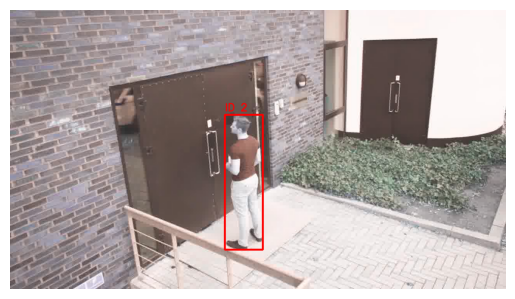

In [6]:
sample_camera = bbox_annotations[12]
# image = cv2.imread(sample_bbox_annot["image"])
# image_with_bbox = annot.draw_bbox(image, sample_bbox_annot)
image_with_bbox = sample_camera.draw_bbox()
plt.imshow(image_with_bbox)
plt.axis("off")

In [7]:
cropped = sample_camera.crop_bbox()

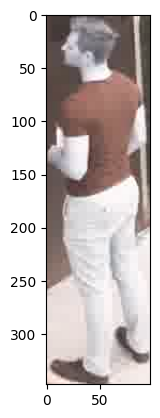

In [8]:
plt.imshow(cropped[0].image)
plt.show()

In [9]:
export_path = DATA_PATH / "pytorch"
for bbox_annot in bbox_annotations:
    cropped = bbox_annot.crop_bbox()
    for crop in cropped:
        crop.export_to_reid(export_path)

In [10]:
annot.prepare_test_set(export_path)